In [23]:
from PIL import Image
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/license_plate/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
from torch.utils.data import *
from imutils import paths
import cv2
import numpy as np
class labelFpsDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        print(img_dir)
        self.img_dir = img_dir
        self.img_paths = []
        print(len(img_dir))
        for i in range(len(img_dir)):
            print(paths.list_images)
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        print(self.img_paths[0])
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        print("running get item")
        print(index)
        img_name = self.img_paths[index]
        print(img_name)
        img = cv2.imread(img_name)
        # img = img.astype('float32')
        resizedImage = cv2.resize(img, self.img_size)
        resizedImage = np.transpose(resizedImage, (2,0,1))
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]

        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
        new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
                      (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]

        return resizedImage, new_labels, lbl, img_name

data_loader = labelFpsDataLoader([data_path],(200,200))
trainloader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)



['/content/gdrive/MyDrive/license_plate/data/']
1
<function list_images at 0x7b18fb3953f0>
/content/gdrive/MyDrive/license_plate/data/1-18_16-193&286_541&526-537&526_193&409_197&286_541&403-0_0_7_31_25_26_21-78-85.jpg


In [29]:
trainloader_iter = iter(trainloader)
print(len(trainloader_iter))
# Get a single batch from the DataLoader
batch = next(trainloader_iter)

running get item
310
/content/gdrive/MyDrive/license_plate/data/0033-2_0-301&467_386&500-385&500_301&496_302&467_386&471-0_0_9_30_30_28_25-101-5.jpg
running get item
527
365
/content/gdrive/MyDrive/license_plate/data/0034-1_4-332&565_420&598-417&598_332&596_335&565_420&567-0_0_19_24_8_32_32-71-5.jpg
running get item
129
/content/gdrive/MyDrive/license_plate/data/0028-3_3-371&489_445&521-445&521_371&516_371&489_445&494-0_0_20_8_32_30_24-85-12.jpg


[226 125 419 173]
original_shape: (268, 500, 3)


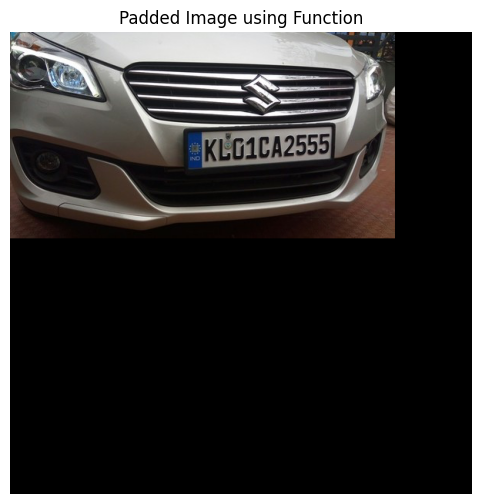

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def parse_boundingbox_label(xml_string):
    root = ET.fromstring(xml_string)

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        bndbox_values = np.array([int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)])

        # bndbox_values = {
        #     'xmin': int(bndbox.find('xmin').text),
        #     'ymin': int(bndbox.find('ymin').text),
        #     'xmax': int(bndbox.find('xmax').text),
        #     'ymax': int(bndbox.find('ymax').text)
        # }

    return bndbox_values

with open('archive (1)/annotations/Cars0.xml') as f:
    xml_string = f.read()

parsed_bndbox = parse_boundingbox_label(xml_string)
print(parsed_bndbox)

def plot_img_and_boundingbox(img, bounding_box_dict):
    img = img.copy()
    img = cv2.rectangle(img, (bounding_box_dict[0], bounding_box_dict[1]), (bounding_box_dict[2], bounding_box_dict[3]), (255, 0, 0), 2)
    plt.imshow(img)
    plt.show()

from typing import Union

def pad_image_to_size(image_path: str, target_size: tuple = (600, 600)) -> Union[Image.Image, None]:
    """
    Pad the image with black pixels such that the size becomes target_size.
    The original image is positioned from (0,0).

    Parameters:
    - image_path (str): Path to the original image file.
    - target_size (tuple): The target size for the padded image (height, width).

    Returns:
    - Image.Image: Padded PIL Image object if successful, None otherwise.
    """
    try:
        # Load the image
        image = Image.open(image_path)
        if image.mode == 'RGBA':
            image = image.convert("RGB")
        # Convert the image to numpy array
        image_np = np.array(image)

        # Get the shape of the original image
        original_shape = image_np.shape
        print(f"original_shape: {original_shape}")
        # Create a black background with the target shape
        padded_shape = (target_size[0], target_size[1], original_shape[2])
        background = np.zeros(padded_shape, dtype=np.uint8)

        # Place the original image onto the black background
        background[0:original_shape[0], 0:original_shape[1]] = image_np

        # Convert the numpy array back to an image
        padded_image = Image.fromarray(background, 'RGB')

        return padded_image
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Test the function
test_image_path = "archive (1)/images/Cars0.png"
result_image = pad_image_to_size(test_image_path)

# Display the result
plt.figure(figsize=(6, 6))
plt.title("Padded Image using Function")
plt.imshow(result_image)
plt.axis('off')
plt.show()


In [ ]:
import keras.utils as image_utils
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np

def load_whole_dataset_wholelicenseplateboundingbox(num_training_samples=300):
    images = []
    bounding_boxes = []
    for i in range(num_training_samples):
        img = pad_image_to_size(f'archive (1)/images/Cars{i}.png', target_size=(600,600))
        img_data = image_utils.img_to_array(img)
        # img_data = np.expand_dims(img_data, axis=0)
        img_preprocessed = preprocess_input(img_data)
        with open(f'archive (1)/annotations/Cars{i}.xml') as f:
            xml_string = f.read()
        parsed_bndbox = parse_boundingbox_label(xml_string)
        images.append(img_preprocessed)
        bounding_boxes.append(parsed_bndbox)
    validation_images = []
    validation_bounding_boxes = []
    for i in range(num_training_samples, num_training_samples+100):
        img = pad_image_to_size(f'archive (1)/images/Cars{i}.png', target_size=(600,600))
        img_data = image_utils.img_to_array(img)
        # img_data = np.expand_dims(img_data, axis=0)
        img_preprocessed = preprocess_input(img_data)
        with open(f'archive (1)/annotations/Cars{i}.xml') as f:
            xml_string = f.read()
        parsed_bndbox = parse_boundingbox_label(xml_string)
        validation_images.append(img_preprocessed)
        validation_bounding_boxes.append(parsed_bndbox)
    return images, bounding_boxes, validation_images, validation_bounding_boxes


original_shape: (268, 500, 3)
original_shape: (248, 400, 3)
original_shape: (400, 400, 3)
original_shape: (225, 400, 3)
original_shape: (350, 590, 3)
original_shape: (295, 400, 3)
original_shape: (375, 500, 3)
original_shape: (279, 400, 3)
original_shape: (232, 500, 3)
original_shape: (333, 442, 3)
original_shape: (225, 400, 3)
original_shape: (305, 400, 3)
original_shape: (141, 400, 3)
original_shape: (268, 400, 3)
original_shape: (225, 400, 3)
original_shape: (267, 400, 3)
original_shape: (221, 400, 3)
original_shape: (267, 400, 3)
original_shape: (388, 507, 3)
original_shape: (240, 400, 3)
original_shape: (244, 400, 3)
original_shape: (301, 400, 3)
original_shape: (299, 400, 3)
original_shape: (299, 400, 3)
original_shape: (300, 400, 3)
original_shape: (225, 400, 3)
original_shape: (225, 400, 3)
original_shape: (225, 400, 3)
original_shape: (425, 600, 3)
original_shape: (299, 400, 3)
original_shape: (240, 400, 3)
original_shape: (245, 400, 3)
original_shape: (300, 400, 3)
original_s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


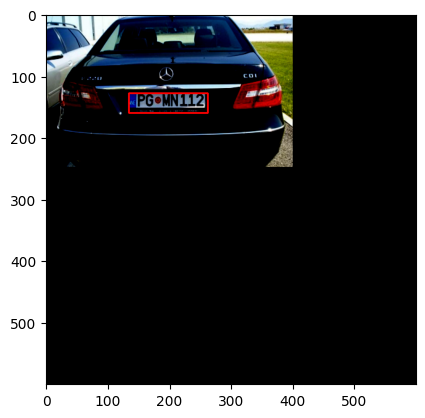

In [ ]:
images, bounding_boxes, validation_images, validation_bounding_boxes = load_whole_dataset_wholelicenseplateboundingbox()
image_numpy = np.array(images)
bounding_boxes_numpy = np.array(bounding_boxes)
validation_images_numpy = np.array(validation_images)
validation_bounding_boxes_numpy = np.array(validation_bounding_boxes)
def plot_img_and_boundingbox(img, boundingbox_vector):
    img = img.copy()
    img = cv2.rectangle(img, (boundingbox_vector[0], boundingbox_vector[1]), (boundingbox_vector[2], boundingbox_vector[3]), (255, 0, 0), 2)
    plt.imshow(img)
    plt.show()

plot_img_and_boundingbox(image_numpy[1], bounding_boxes_numpy[1])

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(600, 600, 3))
# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(4)(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [ ]:
model.compile(optimizer='Adam',loss='mean_squared_error',metrics=['accuracy'])
model.fit(image_numpy, bounding_boxes_numpy, epochs=10, batch_size=1)


Epoch 1/10
300/300 [==============================] - 64s 190ms/step - loss: 7097.2959 - accuracy: 0.8033
Epoch 2/10
300/300 [==============================] - 47s 157ms/step - loss: 3846.8108 - accuracy: 0.8100
Epoch 3/10
300/300 [==============================] - 48s 161ms/step - loss: 3350.1001 - accuracy: 0.8100
Epoch 4/10
300/300 [==============================] - 46s 155ms/step - loss: 3072.1072 - accuracy: 0.8067
Epoch 5/10
300/300 [==============================] - 48s 159ms/step - loss: 2797.4739 - accuracy: 0.8100
Epoch 6/10
300/300 [==============================] - 64s 212ms/step - loss: 2522.6812 - accuracy: 0.8067
Epoch 7/10
300/300 [==============================] - 52s 172ms/step - loss: 2374.4851 - accuracy: 0.8033
Epoch 8/10
300/300 [==============================] - 55s 185ms/step - loss: 2125.1113 - accuracy: 0.8167
Epoch 9/10
300/300 [==============================] - 48s 160ms/step - loss: 1949.5725 - accuracy: 0.8100
Epoch 10/10
300/300 [=========================

1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


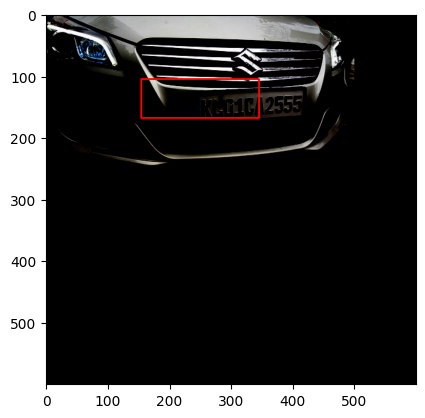

1/1 [==============================] - 0s 149ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


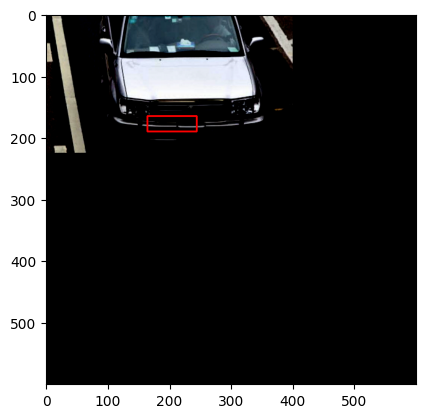

In [ ]:
train_image1 = image_numpy[0]
train_image1 = np.expand_dims(train_image1, axis=0)
predicted_box = model.predict(train_image1)
predicted_box = predicted_box.astype(int)
plot_img_and_boundingbox(image_numpy[0], predicted_box[0])

val_image1 = validation_images_numpy[0]
val_image1 = np.expand_dims(val_image1, axis=0)
predicted_box = model.predict(val_image1)
predicted_box = predicted_box.astype(int)

plot_img_and_boundingbox(validation_images_numpy[0], predicted_box[0])